In [1]:
%tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
1.15.2


In [2]:
pip install keras==2.2.4 # 需要安裝 keras 2.2.4 的版本

     |████████████████████████████████| 317kB 2.8MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [0]:
import xml.etree.ElementTree as ET
import os
import numpy as np

In [4]:
from google.colab import drive 
drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# 下載基於 keras 的 yolov3 程式碼
%cd 'gdrive/My Drive'
# !git clone https://github.com/qqwweee/keras-yolo3 # 如果之前已經下載過就可以註解掉
%cd keras-yolo3

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive
/content/gdrive/My Drive/keras-yolo3


###### 資料集轉換
### 1547張圖片
2858個有戴口罩的邊界框（代號1）
895個未配戴口罩的邊界框（代號0）
117個未正確配戴口罩的邊界框(代號2，有口罩但是配戴方法錯誤）
209個配戴無防護能力口罩的邊界框（代號3）

In [10]:
classes = ["NoMask", "GoodMask", "BadMask", "NoDefMask"]
trainPath = './day49_mask_train.txt'
if not os.path.exists(trainPath):
    list_file = open('./model_data/day49_mask_classes.txt', 'w')
    for data in classes:
        list_file.write(data)
        list_file.write('\n')
    list_file.close()

    maskPath = './data/masked_faces/voc/'
    maskImgPath = './data/masked_faces/imgs/'
    maskFileList = os.listdir(maskPath)
    

    def convert_annotation(fileList, imgPath, path):
        resList = []
        for file in fileList:
            in_file = open(os.path.join(path,file))
            tree=ET.parse(in_file)
            root = tree.getroot()
            filename = root.find('filename').text
            data = os.path.join(imgPath,filename)

            for obj in root.iter('object'):
                difficult = obj.find('difficult').text
                cls = obj.find('name').text
                if int(cls) >= len(classes) or int(difficult) == 1:
                    continue
                cls_id = cls
                xmlbox = obj.find('bndbox')
                b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
                data += (" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))
            resList.append(data)
        return resList

    alllist = convert_annotation(maskFileList, maskImgPath, maskPath)
    np.random.shuffle(alllist)

    list_file = open(trainPath, 'w')
    for data in alllist:
        list_file.write(data)
        list_file.write('\n')
    list_file.close()
    print('Traindata Create Over')
else:
    print("Model exist")


Traindata Create Over


In [0]:
# 當圖片有損壞可用以下代碼找出
# import keras
# from PIL import Image

# kangarooFileList = os.listdir('./data/kangaroo/images/')

# for img in kangarooFileList:
#     try:
#         img2 = Image.open(os.path.join('./data/kangaroo/images/',img))
#         img2.save('test.jpg')
#     except:
#         print(f'{img} loading error')
#         continue

In [5]:
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data
from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

Using TensorFlow backend.


In [12]:
annotation_path = 'day49_mask_train.txt' # 轉換好格式的標註檔案
log_dir = 'logs/day49_mask/' # 訓練好的模型儲存的路徑
classes_path = 'model_data/day49_mask_classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416,416) # multiple of 32, hw

is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/tiny_yolo_weights.h5')
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/yolo_weights.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 分為 training 以及 validation
val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

# Unfreeze and continue training, to fine-tune.
# Train longer if the result is not good.
if True:
    # 把所有 layer 都改為 trainable
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 10 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    hist_model = model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=100,
        initial_epoch=0,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    model.save_weights(log_dir + 'trained_weights_final.h5')


Create YOLOv3 model with 9 anchors and 4 classes.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 27) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((27,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 27) vs (255, 512, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((27,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_75 due to mismatch in shape ((1,

Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.


Unfreeze all of the layers.
Train on 1393 samples, val on 154 samples, with batch size 10.




Epoch 1/100
139/139 [==============================] - 814s 6s/step - loss: 1721.5990 - val_loss: 545.9494

Epoch 2/100
139/139 [==============================] - 120s 865ms/step - loss: 342.1268 - val_loss: 536.8743
Epoch 3/100
139/139 [==============================] - 122s 878ms/step - loss: 201.7745 - val_loss: 200.7564
Epoch 4/100
139/139 [==============================] - 116s 834ms/step - loss: 141.2393 - val_loss: 145.1710
Epoch 5/100
139/139 [==============================] - 121s 869ms/step - loss: 107.5043 - val_loss: 129.6654
Epoch 6/100
139/139 [==============================] - 122s 876ms/step - loss: 87.1140 - val_loss: 93.4316
Epoch 7/100
139/139 [==============================] - 124s 889ms/step - loss: 73.8831 - val_loss: 79.6011
Epoch 8/100
139/139 [==============================] - 

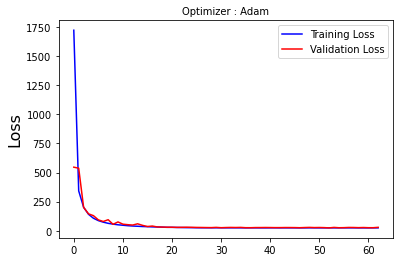

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

In [6]:
annotation_path = 'day49_mask_train.txt' # 轉換好格式的標註檔案
log_dir = 'logs/day49_mask_02/' # 訓練好的模型儲存的路徑
classes_path = 'model_data/day49_mask_classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416,416) # multiple of 32, hw

is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/tiny_yolo_weights.h5')
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/yolo_weights.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 分為 training 以及 validation
val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
if True:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 16
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    # 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
    hist_model1 = model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=50,
            initial_epoch=0,
            callbacks=[logging, checkpoint])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')

# Unfreeze and continue training, to fine-tune.
# Train longer if the result is not good.
if True:
    # 把所有 layer 都改為 trainable
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 5 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    hist_model2 = model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=100,
        initial_epoch=50,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    model.save_weights(log_dir + 'trained_weights_final.h5')














Create YOLOv3 model with 9 anchors and 4 classes.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 27) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((27,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 27) vs (255, 512, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((27,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_75 due to mismatch in shape ((1,

Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 1393 samples, val on 154 samples, with batch size 16.




Epoch 1/50
87/87 [==============================] - 591s 7s/step - loss: 1491.9173 - val_loss: 184.2904

Epoch 2/50
87/87 [==============================] - 93s 1s/step - loss: 137.4001 - val_loss: 99.0155
Epoch 3/50
87/87 [==============================] - 95s 1s/step - loss: 89.0155 - val_loss: 75.5154
Epoch 4/50
87/87 [==============================] - 82s 938ms/step - loss: 69.8217 - val_loss: 61.6806
Epoch 5/50
87/87 [==============================] - 95s 1s/step - loss: 59.5845 - val_loss: 55.0273
Epoch 6/50
87/87 [==============================] - 95s 1s/step - loss: 54.0828 - val_loss: 50.2796
Epoch 7/50
87/87 [==============================] - 95s 1s/step - loss: 49.8416 - val_loss: 48.3055
Epoch 8/50
87/87 [====================

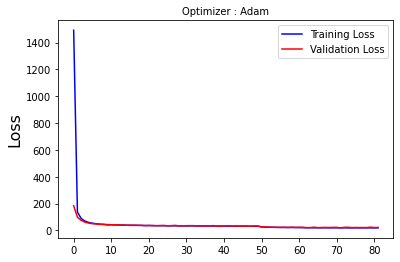

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
loss = np.hstack((hist_model1.history['loss'], hist_model2.history['loss']))
val_loss = np.hstack((hist_model1.history['val_loss'], hist_model2.history['val_loss']))
plt.plot(loss, color='b', label='Training Loss')
plt.plot(val_loss, color='r', label='Validation Loss')
plt.legend(loc='upper right')

In [0]:
from PIL import Image
image = Image.open('./data/masked_faces/imgs/00a95249.jpg')

In [8]:
from yolo import YOLO
yolo_model = YOLO(model_path='logs/day49_mask_02/trained_weights_final.h5', classes_path="model_data/day49_mask_classes.txt")
r_image = yolo_model.detect_image(image)

Using TensorFlow backend.














logs/day49_mask_02/trained_weights_final.h5 model, anchors, and classes loaded.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
(416, 416, 3)
Found 0 boxes for img
7.783499315000029


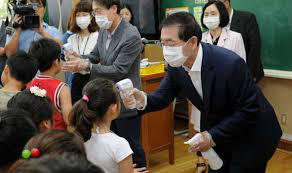

In [9]:
r_image